# RDP for TreeCRF partition estimation

In [1]:
import sys 
sys.path.append('..')

In [2]:
from treecrf import TreeCRFSimulation

In [3]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np
from pandas import DataFrame
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import Adam

In [4]:
%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
!nvidia-smi

Sun Dec  5 20:56:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 15%   36C    P0    24W / 250W |      0MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:DB:00.0 Off |                  N/A |
| 27%   

In [6]:
batch_size = 1
max_len = 15
num_states = 2000
hidden_size = 100
treecrf = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')

In [7]:
treecrf.entropy_approx()

tensor(6.6639, device='cuda:0', grad_fn=<MeanBackward0>)

In [8]:
with torch.no_grad():
    log_Z = treecrf.log_partition()

In [10]:
log_Z

tensor([405.3277], device='cuda:0')

In [69]:
N = 100
with torch.no_grad():
    estimates_0 = []
    estimates_1 = []
    for _ in tqdm(range(100)):
        log_Z_est = treecrf.log_partition_approx(5, 5, proposal)
        estimates_0.append(log_Z_est[0].item())
        
        log_Z_est = treecrf.log_partition_approx(10, 10, proposal)
        estimates_1.append(log_Z_est[0].item())

100%|██████████| 100/100 [00:04<00:00, 21.57it/s]


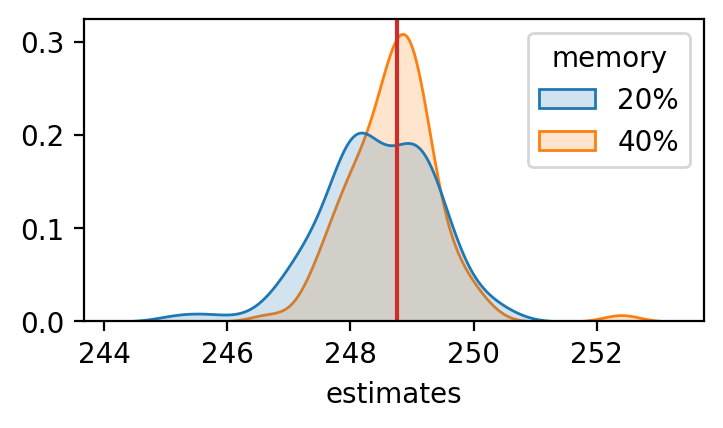

In [70]:
estimates = pd.DataFrame(
                {
                 'estimates': np.array(
                     estimates_0 + estimates_1
                 ), 
                 'memory': np.array(
                                      ['20%'] * N + 
                                      ['40%'] * N
                                     )
                }
            )

plt.figure(figsize=(4,2))
ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
ax.set(ylabel=None)
plt.axvline(x=log_Z, color='#CC2F27')
plt.show()

## Compare TopK function definition

In [9]:
def compare_topk(treecrf, proposal='localglobal', N=100, yloc=[0.2, 0.2], offset=0.1, xlim=None, draw_topk=True):
    with torch.no_grad():
        log_z_exact = treecrf.log_partition()
        log_z_exact = log_z_exact[0].cpu().item()
        log_z_ksum_25 = treecrf.log_partition_approx(K1=500, topk_only=True).cpu().item()
        log_z_ksum_50 = treecrf.log_partition_approx(K1=1000, topk_only=True).cpu().item()

        log_z_est_20 = []
        log_z_est_200 = []
        log_z_est_400 = []
        log_z_est_1000 = []
        for _ in tqdm(range(N)):
            est = treecrf.log_partition_approx(K1=10, K2=10, proposal=proposal)
            log_z_est_20.append(est[0].cpu().item())

            est = treecrf.log_partition_approx(K1=100, K2=100, proposal=proposal)
            log_z_est_200.append(est[0].cpu().item())

            est = treecrf.log_partition_approx(K1=200, K2=200, proposal=proposal)
            log_z_est_400.append(est[0].cpu().item())
            
#             est = treecrf.log_partition_approx(K1=500, K2=500, proposal=proposal)
#             log_z_est_1000.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_20 + log_z_est_200 + log_z_est_400 
#                  + log_z_est_1000
             ), 
             'memory': np.array(
                                  ['1%'] * N
                                  + ['10%'] * N
                                  + ['20%'] * N
#                                   + ['50%'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='memory', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact, color='#CC2F27')
        
        if(draw_topk):
            plt.axvline(x=log_z_ksum_25, color='gray')
            plt.axvline(x=log_z_ksum_50, color='gray')
            plt.text(log_z_ksum_25+offset, yloc[0], 'TopK Sum\n25% Mem', size=9)
            plt.text(log_z_ksum_50+offset, yloc[1], 'TopK Sum\n50% Mem', size=9)
        
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
        plt.xlim(xlim)
        
        print('bias:')
        print(log_z_ksum_25 - log_z_exact, 
              log_z_ksum_50 - log_z_exact, 
              np.mean(log_z_est_20) - log_z_exact, 
              np.mean(log_z_est_200) - log_z_exact, 
              np.mean(log_z_est_400) - log_z_exact,
#               np.mean(log_z_est_1000) - log_z_exact
             )
        print('variance:')
        print(np.var(log_z_est_20), np.var(log_z_est_200), np.var(log_z_est_400),
#               np.var(log_z_est_1000)
             )
        print('mse')
        print((log_z_ksum_25 - log_z_exact)**2, 
              (log_z_ksum_50 - log_z_exact)**2, 
              np.mean((np.array(log_z_est_20) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_200) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_400) - log_z_exact)**2),
#               np.mean((np.array(log_z_est_1000) - log_z_exact)**2)
             )
    return 

## Compare proposal function definition

In [67]:
def compare_proposal(treecrf, N=100, yloc=0.2, offset=0.1, xlim=None):
    with torch.no_grad():
        log_z_exact = treecrf.log_partition()
        log_z_exact = log_z_exact[0].cpu().item()
        log_z_ksum_25 = treecrf.log_partition_approx(K1=500, topk_only=True).cpu().item()
        log_z_ksum_50 = treecrf.log_partition_approx(K1=1000, topk_only=True).cpu().item()

        log_z_est_0 = []
        log_z_est_1 = []
        log_z_est_2 = []
        log_z_est_3 = []
        for _ in tqdm(range(N)):
            est = treecrf.log_partition_approx(K1=100, K2=100, proposal='uniform')
            log_z_est_0.append(est[0].cpu().item())

            est = treecrf.log_partition_approx(K1=100, K2=100, proposal='local')
            log_z_est_1.append(est[0].cpu().item())

            est = treecrf.log_partition_approx(K1=100, K2=100, proposal='global')
            log_z_est_2.append(est[0].cpu().item())
            
            est = treecrf.log_partition_approx(K1=100, K2=100, proposal='localglobal')
            log_z_est_3.append(est[0].cpu().item())

        estimates = pd.DataFrame(
            {
             'estimates': np.array(
                 log_z_est_0 + log_z_est_1 + log_z_est_2 
                 + log_z_est_3
             ), 
             'proposal': np.array(
                                  ['Uniform'] * N
                                  + ['Local Only'] * N
                                  + ['Global Only'] * N
                                  + ['Local Global'] * N
                                 )}
            )

        plt.figure(figsize=(4,2))
        ax = sns.kdeplot(data=estimates, x="estimates", hue='proposal', fill=True, alpha=.2)
        ax.set(ylabel=None)
        plt.axvline(x=log_z_exact, color='#CC2F27')
        
#         plt.axvline(x=log_z_ksum_25, color='gray')
#         plt.axvline(x=log_z_ksum_50, color='gray')
#         plt.text(log_z_ksum_25+offset, yloc, 'TopK Sum\n25% Mem', size=9)
#         plt.text(log_z_ksum_50+offset, yloc, 'TopK Sum\n50% Mem', size=9)
        
        plt.tick_params(axis='both', which='both', left=False, bottom=True, right=False, top=False, labelleft=False, labelbottom=True) 
        # move_legend(ax, 'upper left')
        plt.xlim(xlim)
        
        print('bias:')
        print(
              log_z_ksum_25 - log_z_exact, 
              log_z_ksum_50 - log_z_exact, 
              np.mean(log_z_est_0) - log_z_exact, 
              np.mean(log_z_est_1) - log_z_exact, 
              np.mean(log_z_est_2) - log_z_exact,
              np.mean(log_z_est_3) - log_z_exact
             )
        print('variance:')
        print(np.var(log_z_est_0), np.var(log_z_est_1), np.var(log_z_est_2),
              np.var(log_z_est_3)
             )
        print('mse')
        print((log_z_ksum_25 - log_z_exact)**2, 
              (log_z_ksum_50 - log_z_exact)**2, 
              np.mean((np.array(log_z_est_0) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_1) - log_z_exact)**2), 
              np.mean((np.array(log_z_est_2) - log_z_exact)**2),
              np.mean((np.array(log_z_est_3) - log_z_exact)**2)
             )
    return 

# Dense

In [72]:
batch_size = 1
max_len = 15
num_states = 2000
hidden_size = 100
treecrf_d = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
treecrf_d.entropy_approx()

tensor(6.4544, device='cuda:0', grad_fn=<MeanBackward0>)

## Compare to TopK 

100%|██████████| 100/100 [00:07<00:00, 13.91it/s]


bias:
-6.0106201171875 -1.685882568359375 -4.201201477050802 -0.5766711425781068 -0.23732482910156705
variance:
7.309940048241149 0.753206262486428 0.421870012492314
mse
36.127554193139076 2.8422000342980027 24.960033899014817 1.0857558691687883 0.4781930870003998


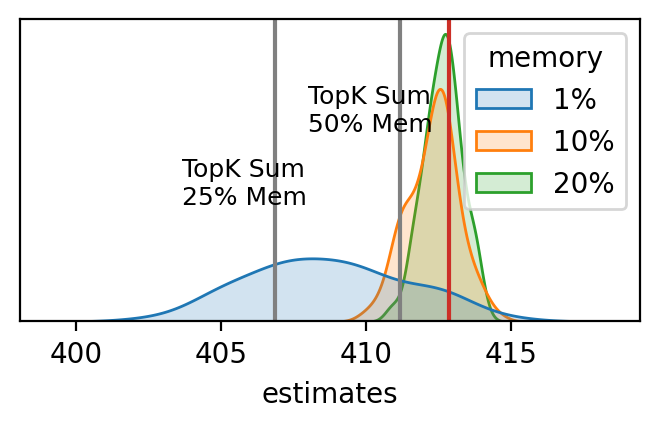

In [103]:
compare_topk(treecrf_d, proposal='uniform', N=100, yloc=[0.08, 0.13], offset=-3.2)

## Compare proposal

100%|██████████| 100/100 [00:08<00:00, 11.40it/s]


bias:
-6.362396240234375 -1.924224853515625 -0.8192462158203284 0.4600970458984648 -0.45199981689455626 0.895541992187475
variance:
1.1422912473198028 1.5992336710248145 1.145374651805591 3.189739527651667
mse
40.48008591774851 3.7026412868872285 1.8134556094557046 1.810922962669283 1.3496784862782807 3.991734987422824


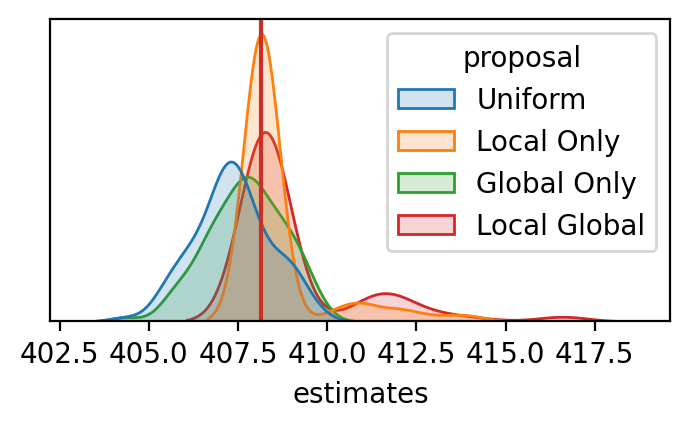

In [68]:
compare_proposal(treecrf_d, N=100)

## Compare K1K2

# Intermediate

In [33]:
batch_size = 1
max_len = 15
num_states = 2000
hidden_size = 100
treecrf_i = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(treecrf_i.entropy_approx())

optimizer = Adam(treecrf_i.parameters(), lr=1e-4)
for _ in tqdm(range(30)):
    treecrf_i.zero_grad()
    ent = treecrf_i.entropy_approx()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 30/30 [00:00<00:00, 666.13it/s]

tensor(6.5580, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.3316, device='cuda:0', grad_fn=<MeanBackward0>)


## Compare topK

100%|██████████| 100/100 [00:07<00:00, 13.93it/s]


bias:
-5.23785400390625 -1.55059814453125 -4.766466979980464 -0.6857385253906045 -0.11012023925781023
variance:
9.91888221502481 0.9550137210838495 0.3878784805756063
mse
27.435114566236734 2.4043546058237553 32.63808968626894 1.4252510462887584 0.4000049476698041


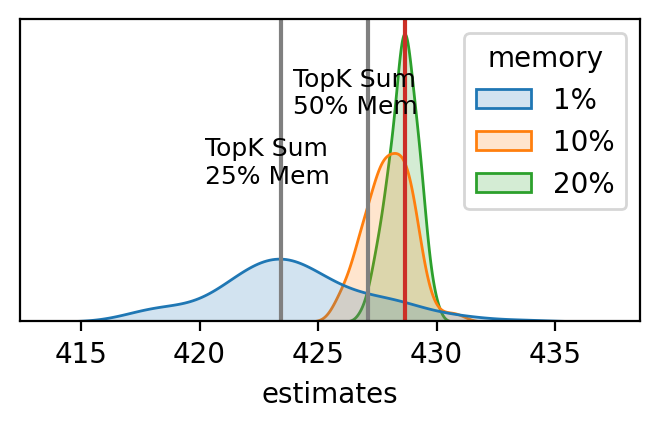

In [104]:
compare_topk(treecrf_i, proposal='uniform', N=100, yloc=[0.1, 0.15], offset=-3.2)

## Compare proposal

100%|██████████| 100/100 [00:08<00:00, 11.32it/s]


bias:
-5.23785400390625 -1.55059814453125 -0.34620269775388124 0.9572244262695335 -0.5351858520508017 1.044406738281225
variance:
0.9348041997040621 3.463397139982413 0.9839691950465553 3.056393900891394
mse
27.435114566236734 2.4043546058237553 1.0546605076361448 4.3796757422294466 1.270393091281876 4.147179335858673


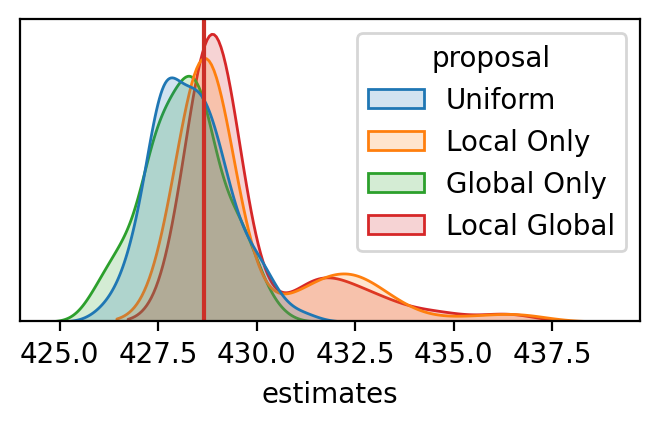

In [69]:
compare_proposal(treecrf_i, N=100)

# Long-tail

In [35]:
batch_size = 1
max_len = 15
num_states = 2000
hidden_size = 100
treecrf_l = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(treecrf_l.entropy_approx())

optimizer = Adam(treecrf_l.parameters(), lr=1e-4)
for _ in tqdm(range(50)):
    treecrf_l.zero_grad()
    ent = treecrf_l.entropy_approx()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 50/50 [00:00<00:00, 708.35it/s]

tensor(6.5946, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(6.2147, device='cuda:0', grad_fn=<MeanBackward0>)


## Compare topk

100%|██████████| 100/100 [00:07<00:00, 13.74it/s]


bias:
-4.666778564453125 -1.431060791015625 -6.476434936523447 -0.6448370361327989 -0.1448965454101767
variance:
13.461674892928079 1.1124274864975363 0.45531087691811833
mse
21.77882216963917 2.0479349875822663 55.40588437994942 1.5282422896660863 0.4763058857899159


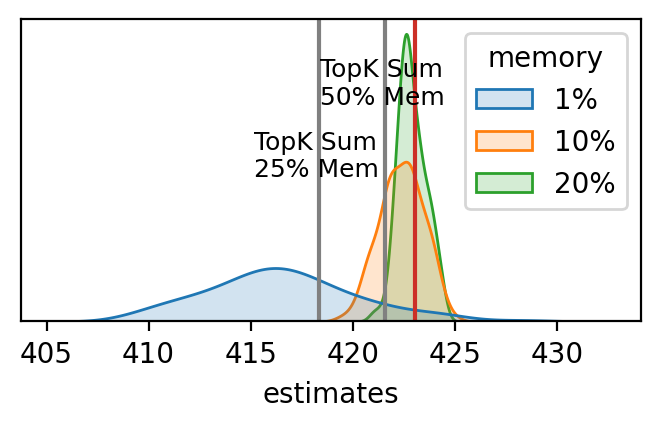

In [105]:
compare_topk(treecrf_l, proposal='uniform', N=100,  yloc=[0.1, 0.15], offset=-3.2)

## Compare proposal

In [ ]:
compare_proposal(treecrf_l, N=100)

# Below we change N = 10000

In [11]:
batch_size = 1
max_len = 5
num_states = 10000
hidden_size = 50
treecrf = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')

## N = 10000, Dense, compare topk

100%|██████████| 100/100 [00:01<00:00, 80.17it/s]


bias:
-8.867477416992188 -5.9940948486328125 -1.2973429870605457 -0.13959777832030795 -0.04153579711913835
variance:
1.6933966409231302 0.2796253197774291 0.1468273963923333
mse
78.63215574086644 35.92917305440642 3.3764954669983127 0.2991128594893962 0.14855261883465573


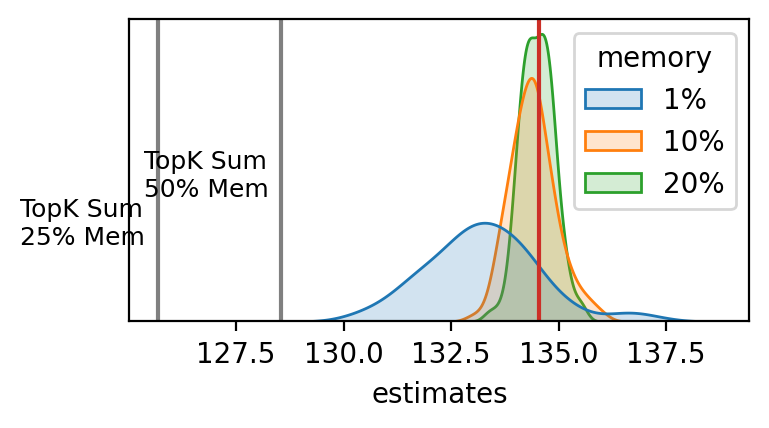

In [12]:
compare_topk(treecrf, proposal='uniform', N=100, yloc=[0.08, 0.13], offset=-3.2)

## N = 10000, Intermediate

In [13]:
batch_size = 1
max_len = 5
num_states = 10000
hidden_size = 50
treecrf_i = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(treecrf_i.entropy_approx())

optimizer = Adam(treecrf_i.parameters(), lr=1e-4)
for _ in tqdm(range(30)):
    treecrf_i.zero_grad()
    ent = treecrf_i.entropy_approx()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 30/30 [00:00<00:00, 638.13it/s]

tensor(8.3552, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.2253, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 100/100 [00:01<00:00, 80.26it/s]


bias:
-7.98516845703125 -5.1649932861328125 -1.5253205871582054 -0.3100468444824287 -0.06163223266602813
variance:
2.686153205638263 0.3513406841124175 0.2428724618426291
mse
63.762915287166834 26.67715564579703 5.012756099246908 0.4474697298859246 0.246670993946027


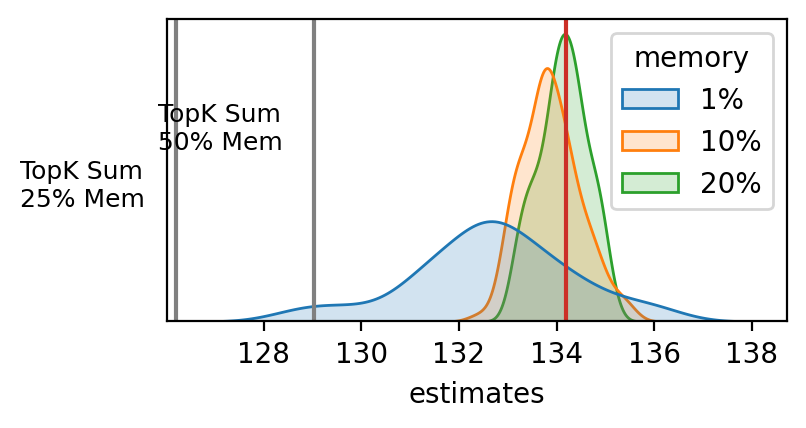

In [14]:
compare_topk(treecrf_i, proposal='uniform', N=100, yloc=[0.1, 0.15], offset=-3.2)

## N = 10000, Long tail

In [16]:
batch_size = 1
max_len = 5
num_states = 10000
hidden_size = 50
treecrf_l = TreeCRFSimulation(batch_size, max_len, num_states, hidden_size).to('cuda')
print(treecrf_l.entropy_approx())

optimizer = Adam(treecrf_l.parameters(), lr=1e-4)
for _ in tqdm(range(50)):
    treecrf_l.zero_grad()
    ent = treecrf_l.entropy_approx()
    ent.backward()
    optimizer.step()
print(ent)

100%|██████████| 50/50 [00:00<00:00, 604.01it/s]

tensor(8.2594, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(8.0122, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 100/100 [00:01<00:00, 79.77it/s]


bias:
-6.5997467041015625 -4.1351318359375 -2.0637342834472747 -0.2444827270507801 -0.17930999755859034
variance:
2.9972021209816218 0.5163915302799084 0.26224409899963064
mse
43.55665655829944 17.09931530058384 7.25620131365722 0.5761633341060951 0.29439617422409353


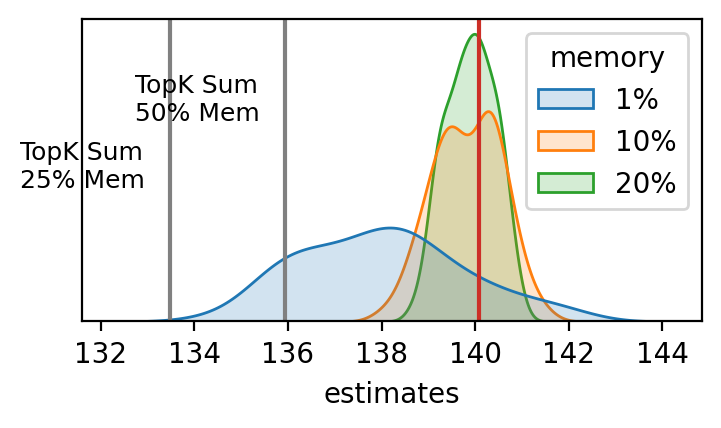

In [17]:
compare_topk(treecrf_l, proposal='uniform', N=100,  yloc=[0.1, 0.15], offset=-3.2)